## 최적화 방법

지금까지 항상 Gradient Descent를 사용하여 매개 변수를 업데이트하고 비용을 최소화했습니다. 이 노트북에서는 학습 속도를 높이고 비용 함수에 대한 더 나은 최종 값을 얻을 수 있는 고급 최적화 방법을 배우게 됩니다. 좋은 최적화 알고리즘을 갖는 것은 좋은 결과를 얻기 위해 기다리는 일과 단 몇 시간의 차이 일 수 있습니다.

경사하강법은 비용 함수 $J $에서 "내리막"으로 이동합니다. 이것을 시도하는 것으로 생각하십시오.

<img src="./images/cost.jpg" width="500">

**그림 1** : 비용 최소화는 언덕이 많은 풍경에서 가장 낮은 지점을 찾는 것과 같습니다. 훈련의 각 단계에서 가능한 가장 낮은 지점에 도달하기 위해 특정 방향에 따라 매개 변수를 업데이트합니다.

**표기법** : 평소와 같이 변수 a에 대해 $ \frac {\partial J} {\partial a} \rightarrow $ da 로 표기.

시작하려면 다음 코드를 실행하여 필요한 라이브러리를 가져옵니다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

from opt_utils_v1a import load_params_and_grads, initialize_parameters, forward_propagation, backward_propagation
from opt_utils_v1a import compute_cost, predict, predict_dec, plot_decision_boundary, load_dataset
from testCases_6 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### 1. 경사하강법
머신 러닝의 간단한 최적화 방법은 경사하강법(GD)입니다. 각 단계의 모든 $m $ 예제와 관련하여 기울기 단계를 수행하는 경우, 이를 Batch Gradient Descent라고도 합니다.

**워밍업 연습과제** : 경사하강법 업데이트 규칙을 구현합니다. $ l = 1, ..., L $에 대한 경사하강법 규칙은:
$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{1}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{2}$$

여기서 $L$은 레이어의 수이고 $\alpha $는 학습률입니다. 모든 매개변수는 매개변수 딕셔너리에 저장되어야 합니다. 반복자 $l$의 첫 번째 매개변수는 $ W^{[1]} $ 및 $ b^{[1]} $입니다. 

In [53]:
# GRADED FUNCTION: update_parameters_with_gd

def update_parameters_with_gd(parameters, grads, learning_rate):
    """
    Update parameters using one step of gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters to be updated:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients to update each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    learning_rate -- the learning rate, scalar.
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(parameters) // 2 # number of layers in the neural networks

    # Update rule for each parameter
    for l in range(1,L+1):
        ### START CODE HERE ### (approx. 2 lines)
        parameters["W" + str(l)] -= learning_rate * grads['dW' + str(l)]
        parameters["b" + str(l)] -= learning_rate * grads['db' + str(l)]
        ### END CODE HERE ###
        
    return parameters

parameters, grads, learning_rate = update_parameters_with_gd_test_case()

parameters = update_parameters_with_gd(parameters, grads, learning_rate)
print("W1 =\n" + str(parameters["W1"]))
print("b1 =\n" + str(parameters["b1"]))
print("W2 =\n" + str(parameters["W2"]))
print("b2 =\n" + str(parameters["b2"]))

W1 =
[[ 1.63535156 -0.62320365 -0.53718766]
 [-1.07799357  0.85639907 -2.29470142]]
b1 =
[[ 1.74604067]
 [-0.75184921]]
W2 =
[[ 0.32171798 -0.25467393  1.46902454]
 [-2.05617317 -0.31554548 -0.3756023 ]
 [ 1.1404819  -1.09976462 -0.1612551 ]]
b2 =
[[-0.88020257]
 [ 0.02561572]
 [ 0.57539477]]


**Expected Output**:

```
W1 =
[[ 1.63535156 -0.62320365 -0.53718766]
 [-1.07799357  0.85639907 -2.29470142]]
b1 =
[[ 1.74604067]
 [-0.75184921]]
W2 =
[[ 0.32171798 -0.25467393  1.46902454]
 [-2.05617317 -0.31554548 -0.3756023 ]
 [ 1.1404819  -1.09976462 -0.1612551 ]]
b2 =
[[-0.88020257]
 [ 0.02561572]
 [ 0.57539477]]
```

이것의 변형은 SGD(Stochastic Gradient Descent)로, 각 미니 배치에는 단 하나의 예만 있는 미니-배치 경사하강법과 동일합니다. 방금 구현한 업데이트 규칙은 변경되지 않습니다. 변경된 점은 전체 학습 세트가 아닌 한 번에 하나의 학습 예제에서만 그라디언트를 계산한다는 것입니다. 아래 코드 예제는 확률적 경사하강법과 (일괄) 경사하강법의 차이점을 보여줍니다.

- **(Batch) Gradient Descent**:

``` python
X = data_input
Y = labels
parameters = initialize_parameters(layers_dims)
for i in range(0, num_iterations):
    # Forward propagation
    a, caches = forward_propagation(X, parameters)
    # Compute cost.
    cost += compute_cost(a, Y)
    # Backward propagation.
    grads = backward_propagation(a, caches, parameters)
    # Update parameters.
    parameters = update_parameters(parameters, grads)
        
```

- **Stochastic Gradient Descent**:

```python
X = data_input
Y = labels
parameters = initialize_parameters(layers_dims)
for i in range(0, num_iterations):
    for j in range(0, m):
        # Forward propagation
        a, caches = forward_propagation(X[:,j], parameters)
        # Compute cost
        cost += compute_cost(a, Y[:,j])
        # Backward propagation
        grads = backward_propagation(a, caches, parameters)
        # Update parameters.
        parameters = update_parameters(parameters, grads)
```


확률적 경사하강법에서는 그라디언트를 업데이트하기 전에 하나의 훈련 예제만 사용합니다. 훈련 세트가 크면 SGD가 더 빠를 수 있습니다. 그러나 매개 변수는 매끄럽게 수렴하지 않고 최소값방향으로 "진동"하게 됩니다. 다음은 이에 대한 설명입니다.

<img src="./images/kiank_sgd.png" width="600">

**그림 1** : **SGD vs GD** : 
"+"는 최소 비용을 나타냅니다. SGD는 수렴에 도달하기 위해 많은 진동을 유발합니다. 그러나 각 단계는 하나의 학습 예제 (GD의 전체 배치와 비교) 만 사용하므로 GD보다 SGD 계산이 훨씬 빠릅니다.

SGD를 구현하려면 총 3개의 for 루프가 필요합니다.

* 반복 수에 대하여
* $m$ 훈련 자료에 대하여
* 레이어들에 대하여 ($ (W^{[1]}, b^{[1]})$ 부터 $ (W^{[L]}, b^{[L]}) $ 까지의 모든 매개변수 업데이트)


실제로 각 업데이트를 수행하는 데 전체 학습 세트를 사용하지 않거나 하나의 학습 예제 만 사용하지 않으면 더 빠른 결과를 얻을 수 있습니다. 미니-배치 경사하강법은 각 단계에 대해 중간 수의 예제를 사용합니다. 미니-배치 경사하강법을 사용하면 개별 훈련 예제를 반복하는 대신 미니-배치를 반복합니다.

<img src="./images/kiank_minibatch.png" width="600">

**그림 2** : **SGD vs Mini-Batch GD**
"+"는 최소 비용을 나타냅니다. 최적화 알고리즘에서 미니 배치를 사용하면 종종 더 빠른 최적화로 이어집니다.

* 경사하강법, 미니-배치 경사하강법 및 확률적 경사하강법의 차이점은 하나의 업데이트 단계를 수행하는 데 사용하는 예제의 수입니다.
* 학습률 초매개변수 $\alpha $를 조정해야 합니다.
* 잘 전환된 미니-배치 크기를 사용하면 일반적으로 경사하강법 또는 확률적 경사하강법 (특히 훈련 세트가 큰 경우)보다 성능이 우수합니다.


### 2. 미니-배치 경사하강법

훈련 세트 $(X, Y)$에서 미니 배치를 만드는 방법을 알아 보겠습니다.

두 단계가 있습니다.

**셔플** : 아래와 같이 훈련 세트 (X, Y)의 셔플 버전을 만듭니다. X와 Y의 각 열은 학습 예제를 나타냅니다. 임의 셔플링은 X와 Y간에 동기적으로 수행됩니다. 셔플링 후 X의 $ i ^ {th} $ 열은 Y의 $ i ^ {th} $ 레이블에 해당하는 예입니다. 셔플링 단계는 다음을 보장합니다. 예는 무작위로 다른 미니 배치로 나뉩니다.

<img src="./images/kiank_shuffle.png" width="600">

**분할(partition)** : 셔플된 (X, Y)을 `mini_batch_size` (여기서는 64) 크기의 미니 배치로 분할합니다. 학습 예제의 수가 항상 `mini_batch_size`로 나눌 수 있는 것은 아닙니다. 마지막 미니 배치는 더 작을 수 있지만 이에 대해 걱정할 필요가 없습니다. 최종 미니 배치가 전체 `mini_batch_size` 보다 작으면 다음과 같이 표시됩니다.

<img src="./images/kiank_partition.png" width="600">


**(1) 연습문제** : `random_mini_batches`를 구현하십시오. 셔플링 부분을 코딩했습니다. 파티셔닝 단계를 돕기 위해 $ 1^{st} $ 및 $ 2^{nd} $ 미니-배치에 대한 인덱스를 선택하는 다음 코드를 제공합니다.
```python
first_mini_batch_X = shuffled_X [:, 0 : mini_batch_size]
second_mini_batch_X = shuffled_X [:, mini_batch_size : 2 * mini_batch_size]
...
```
마지막 미니-배치는 `mini_batch_size = 64` 보다 작아 질 수 있습니다. $ \lfloor s \rfloor $는 가장 가까운 정수로 내림한 $ s $를 나타냅니다 (파이썬의 `math.floor(s)`). 총 예제 수가 `mini_batch_size = 64`의 배수가 아닌 경우 전체 64 개의 예제와 예제 수가 있는 $\lfloor \frac{m}{mini\_batch\_size}\rfloor$  미니-배치가 있습니다. 최종 미니-배치는 (
$m - \text{mini_batch_size} \times \lfloor \frac{m}{\text{mini_batch_size}}\rfloor$
)입니다.



In [2]:
# GRADED FUNCTION: random_mini_batches

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[:,k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:,k*mini_batch_size:(k+1)*mini_batch_size]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[:,-(m-mini_batch_size*num_complete_minibatches):]
        mini_batch_Y = shuffled_Y[:,-(m-mini_batch_size*num_complete_minibatches):]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

X_assess, Y_assess, mini_batch_size = random_mini_batches_test_case()
mini_batches = random_mini_batches(X_assess, Y_assess, mini_batch_size)

print ("shape of the 1st mini_batch_X: " + str(mini_batches[0][0].shape))
print ("shape of the 2nd mini_batch_X: " + str(mini_batches[1][0].shape))
print ("shape of the 3rd mini_batch_X: " + str(mini_batches[2][0].shape))
print ("shape of the 1st mini_batch_Y: " + str(mini_batches[0][1].shape))
print ("shape of the 2nd mini_batch_Y: " + str(mini_batches[1][1].shape)) 
print ("shape of the 3rd mini_batch_Y: " + str(mini_batches[2][1].shape))
print ("mini batch sanity check: " + str(mini_batches[0][0][0][0:3]))

shape of the 1st mini_batch_X: (12288, 64)
shape of the 2nd mini_batch_X: (12288, 64)
shape of the 3rd mini_batch_X: (12288, 20)
shape of the 1st mini_batch_Y: (1, 64)
shape of the 2nd mini_batch_Y: (1, 64)
shape of the 3rd mini_batch_Y: (1, 20)
mini batch sanity check: [ 0.90085595 -0.7612069   0.2344157 ]


**Expected Output**:

<table style="width:90%"> 
    <tr>
    <td width="40%"> shape of the 1st mini_batch_X </td> 
           <td > (12288, 64) </td> 
    </tr> 
    <tr>
    <td > shape of the 2nd mini_batch_X </td> 
           <td > (12288, 64) </td> 
    </tr> 
    <tr>
    <td > shape of the 3rd mini_batch_X </td> 
           <td > (12288, 20) </td> 
    </tr>
    <tr>
    <td > shape of the 1st mini_batch_Y </td> 
           <td > (1, 64) </td> 
    </tr> 
    <tr>
    <td > shape of the 2nd mini_batch_Y </td> 
           <td > (1, 64) </td> 
    </tr> 
    <tr>
    <td > shape of the 3rd mini_batch_Y </td> 
           <td > (1, 20) </td> 
    </tr> 
    <tr>
    <td > mini batch sanity check </td> 
           <td > [ 0.90085595 -0.7612069   0.2344157 ] </td> 
    </tr>
</table>

* 셔플링 및 분할은 미니-배치를 구축하는 데 필요한 두 단계입니다.
* 2의 거듭 제곱은 종종 미니-배치 크기로 선택됩니다 (예 : 16, 32, 64, 128).

### 3. 모멘텀

미니-배치 경사하강법은 예제의 일부만 본 후에 매개변수를 업데이트하기 때문에 업데이트 방향에 약간의 차이가 있으므로 미니-배치 경사하강법이 사용하는 경로가 수렴 방향으로 "진동"됩니다. 운동량을 사용하면 이러한 진동을 줄일 수 있습니다.

Momentum은 업데이트를 부드럽게하기 위해 과거 그라디언트를 고려합니다. 변수 $v$ 에 이전 그라디언트의 '방향'을 저장합니다. 공식적으로 이것은 이전 단계에서 기울기의 지수 가중치 평균이 됩니다. $ v $는 언덕의 경사/경사 방향에 따라 속도(및 운동량)를 높이는 내리막으로 굴러가는 공의 "속도"로 생각할 수도 있습니다.

<img src="./images/opt_momentum.png" width="400">

**그림 3** : 빨간색 화살표는 운동량이 있는 미니 배치 경사하강법의 한 단계가 취하는 방향을 보여줍니다. 파란색 점은 각 단계의 그라데이션 방향 (현재 미니 배치 기준)을 나타냅니다. 단순히 그라디언트를 따르는 것이 아니라 그라디언트가 𝑣에 영향을 미치도록 한 다음 𝑣 방향으로 한 걸음 나아갑니다.

**(2) 연습문제** : 속도를 초기화합니다. 속도 $v$은 0 배열로 초기화 해야하는 파이썬 딕셔너리입니다. 키는 `grads` 딕셔너리의 키와 동일합니다. 즉, for $l =1,...,L$ :
```python
v["dW" + str(l)] = ... #(numpy array of zeros with the same shape as parameters["W" + str(l)])
v["db" + str(l)] = ... #(numpy array of zeros with the same shape as parameters["b" + str(l)])
```

In [55]:
# GRADED FUNCTION: initialize_velocity

def initialize_velocity(parameters):
    """
    Initializes the velocity as a python dictionary with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    
    Returns:
    v -- python dictionary containing the current velocity.
                    v['dW' + str(l)] = velocity of dWl
                    v['db' + str(l)] = velocity of dbl
    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    
    # Initialize velocity
    for l in range(1,L+1):
        ### START CODE HERE ### (approx. 2 lines)
        v["dW" + str(l)] = 
        v["db" + str(l)] = 
        ### END CODE HERE ###
        
    return v

parameters = initialize_velocity_test_case()

v = initialize_velocity(parameters)
print("v[\"dW1\"] =\n" + str(v["dW1"]))
print("v[\"db1\"] =\n" + str(v["db1"]))
print("v[\"dW2\"] =\n" + str(v["dW2"]))
print("v[\"db2\"] =\n" + str(v["db2"]))

v["dW1"] =
[[0. 0. 0.]
 [0. 0. 0.]]
v["db1"] =
[[0.]
 [0.]]
v["dW2"] =
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v["db2"] =
[[0.]
 [0.]
 [0.]]


**Expected Output**:

```
v["dW1"] =
[[ 0.  0.  0.]
 [ 0.  0.  0.]]
v["db1"] =
[[ 0.]
 [ 0.]]
v["dW2"] =
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
v["db2"] =
[[ 0.]
 [ 0.]
 [ 0.]]
```

**(3) 연습과제** : 이제 모멘텀으로 매개변수 업데이트를 구현하십시오. 운동량 업데이트 규칙은 $ l = 1, ..., L $입니다.

$$ \begin{cases}
v_{dW^{[l]}} = \beta v_{dW^{[l]}} + (1 - \beta) dW^{[l]} \\
W^{[l]} = W^{[l]} - \alpha v_{dW^{[l]}}
\end{cases}\tag{3}$$

$$\begin{cases}
v_{db^{[l]}} = \beta v_{db^{[l]}} + (1 - \beta) db^{[l]} \\
b^{[l]} = b^{[l]} - \alpha v_{db^{[l]}} 
\end{cases}\tag{4}$$

여기서 $L$은 레이어 수, $ \beta $는 모멘텀, $ \alpha $는 학습률입니다. 모든 매개 변수는 매개 변수 사전에 저장되어야 합니다. 반복기 $l$은 for 루프에서 0에서 시작하는 반면 첫 번째 매개 변수는 $ W^{[1]} $ 및 $ b^{[1]} $ (위 첨자에서 "$1$")입니다. 따라서 코딩 할 때 $l$을 $l + 1$로 이동해야 합니다.

In [56]:
# GRADED FUNCTION: update_parameters_with_momentum

def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    """
    Update parameters using Momentum
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- python dictionary containing the current velocity:
                    v['dW' + str(l)] = ...
                    v['db' + str(l)] = ...
    beta -- the momentum hyperparameter, scalar
    learning_rate -- the learning rate, scalar
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- python dictionary containing your updated velocities
    """

    L = len(parameters) // 2 # number of layers in the neural networks
    
    # Momentum update for each parameter
    for l in range(1,L+1):
        
        ### START CODE HERE ### (approx. 4 lines)
        # compute velocities
        v["dW" + str(l)] = 
        v["db" + str(l)] = 
        # update parameters
        parameters["W" + str(l)] 
        parameters["b" + str(l)] 
        ### END CODE HERE ###
        
    return parameters, v

parameters, grads, v = update_parameters_with_momentum_test_case()

parameters, v = update_parameters_with_momentum(parameters, grads, v, beta = 0.9, learning_rate = 0.01)
print("W1 = \n" + str(parameters["W1"]))
print("b1 = \n" + str(parameters["b1"]))
print("W2 = \n" + str(parameters["W2"]))
print("b2 = \n" + str(parameters["b2"]))
print("v[\"dW1\"] = \n" + str(v["dW1"]))
print("v[\"db1\"] = \n" + str(v["db1"]))
print("v[\"dW2\"] = \n" + str(v["dW2"]))
print("v[\"db2\"] = v" + str(v["db2"]))

W1 = 
[[ 1.62544598 -0.61290114 -0.52907334]
 [-1.07347112  0.86450677 -2.30085497]]
b1 = 
[[ 1.74493465]
 [-0.76027113]]
W2 = 
[[ 0.31930698 -0.24990073  1.4627996 ]
 [-2.05974396 -0.32173003 -0.38320915]
 [ 1.13444069 -1.0998786  -0.1713109 ]]
b2 = 
[[-0.87809283]
 [ 0.04055394]
 [ 0.58207317]]
v["dW1"] = 
[[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = 
[[-0.01228902]
 [-0.09357694]]
v["dW2"] = 
[[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = v[[0.02344157]
 [0.16598022]
 [0.07420442]]


**Expected Output**:

```
W1 = 
[[ 1.62544598 -0.61290114 -0.52907334]
 [-1.07347112  0.86450677 -2.30085497]]
b1 = 
[[ 1.74493465]
 [-0.76027113]]
W2 = 
[[ 0.31930698 -0.24990073  1.4627996 ]
 [-2.05974396 -0.32173003 -0.38320915]
 [ 1.13444069 -1.0998786  -0.1713109 ]]
b2 = 
[[-0.87809283]
 [ 0.04055394]
 [ 0.58207317]]
v["dW1"] = 
[[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = 
[[-0.01228902]
 [-0.09357694]]
v["dW2"] = 
[[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = v[[ 0.02344157]
 [ 0.16598022]
 [ 0.07420442]]
```

**참고** :

* 속도는 0으로 초기화 됩니다. 따라서 알고리즘은 속도를 "구축"하고 더 큰 단계를 수행하기 위해 몇 번의 반복이 필요합니다.
* $ \beta = 0 $이면 이것은 모멘텀이 없는 표준 경사하강법이됩니다.

#### $\beta$는 어떻게 선택합니까?

* $ \beta $ 모멘텀이 클수록 과거의 그래디언트를 더 많이 고려하기 때문에 업데이트가 더 부드러워집니다. 그러나 $ \beta $가 너무 크면 업데이트가 너무 부드러워질 수도 있습니다.
* $ \beta $의 일반적인 값은 0.8에서 0.999까지입니다. 이것을 조정하고 싶지 않다면 $ \beta = 0.9 $가 합리적인 기본값입니다.
* 모델에 대한 최적의 $ \beta $를 조정하려면 비용 함수 $ J $의 값을 줄이는 측면에서 가장 효과적인 것을 확인하기 위해 여러 값을 시도해야 할 수 있습니다.

모멘텀은 경사하강 단계를 매끄럽게 하기 위해 과거 기울기를 고려합니다. 배치 경사하강법, 미니-배치 경사하강법 또는 확률적 경사하강법에 적용 할 수 있습니다.
운동량 하이퍼 파라미터 $ \beta $와 학습률 $ \alpha $를 조정해야 합니다.

### 4. Adam
Adam은 신경망 훈련을 위한 가장 효과적인 최적화 알고리즘 중 하나입니다. RMSProp (강의에서 설명)와 Momentum의 아이디어를 결합합니다.

**Adam은 어떻게 작동합니까?**

1. 과거 기울기의 지수 가중치 평균을 계산하고 변수 $ v $ (편향 보정 전) 및 $ v ^{corrected} $ (편향 보정 포함)에 저장합니다.
2. 과거 그래디언트 제곱의 지수 가중 평균을 계산하고 변수 $ s $ (편향 수정 전) 및 $ s ^{corrected} $ (편향 수정 포함)에 저장합니다.
3. "1"과 "2"의 정보를 결합하여 방향으로 매개 변수를 업데이트합니다.

업데이트 규칙은 $ l=1, ..., L $입니다.

$$\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$

여기서:

* $t$는 Adam이 취한 걸음 수를 계산합니다.
* $L$은 레이어 수입니다.
* $ \beta_1 $ 및 $ \beta_2 $는 두 지수 가중치 평균을 제어하는 초매개변수입니다.
* $ \alpha $는 학습률입니다.
* $ \varepsilon $은 0으로 나누는 것을 피하기 위해 매우 작은 숫자입니다.

평소와 같이 모든 매개 변수를 매개 변수 사전에 저장합니다.

**(4) 연습과제** : 과거 정보를 추적하는 Adam 변수 $ v, s $를 초기화합니다.

**지시사항** : 변수 $ v, s $는 0 배열로 초기화해야하는 파이썬 사전입니다. 그들의 키는 그라디언트의 경우와 동일합니다. 즉, $l = 1, ..., L $ :

```
v["dW" + str(l)] = ... #(numpy array of zeros with the same shape as parameters["W" + str(l)])
v["db" + str(l)] = ... #(numpy array of zeros with the same shape as parameters["b" + str(l)])
s["dW" + str(l)] = ... #(numpy array of zeros with the same shape as parameters["W" + str(l)])
s["db" + str(l)] = ... #(numpy array of zeros with the same shape as parameters["b" + str(l)])
```

In [58]:
# GRADED FUNCTION: initialize_adam

def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(1,L+1):
    ### START CODE HERE ### (approx. 4 lines)
        v["dW" + str(l)] = 
        v["db" + str(l)] = 
        s["dW" + str(l)] = 
        s["db" + str(l)] = 
    ### END CODE HERE ###
    
    return v, s

parameters = initialize_adam_test_case()

v, s = initialize_adam(parameters)
print("v[\"dW1\"] = \n" + str(v["dW1"]))
print("v[\"db1\"] = \n" + str(v["db1"]))
print("v[\"dW2\"] = \n" + str(v["dW2"]))
print("v[\"db2\"] = \n" + str(v["db2"]))
print("s[\"dW1\"] = \n" + str(s["dW1"]))
print("s[\"db1\"] = \n" + str(s["db1"]))
print("s[\"dW2\"] = \n" + str(s["dW2"]))
print("s[\"db2\"] = \n" + str(s["db2"]))

v["dW1"] = 
[[0. 0. 0.]
 [0. 0. 0.]]
v["db1"] = 
[[0.]
 [0.]]
v["dW2"] = 
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v["db2"] = 
[[0.]
 [0.]
 [0.]]
s["dW1"] = 
[[0. 0. 0.]
 [0. 0. 0.]]
s["db1"] = 
[[0.]
 [0.]]
s["dW2"] = 
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
s["db2"] = 
[[0.]
 [0.]
 [0.]]


**Expected Output**:

```
v["dW1"] = 
[[0. 0. 0.]
 [0. 0. 0.]]
v["db1"] = 
[[0.]
 [0.]]
v["dW2"] = 
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v["db2"] = 
[[0.]
 [0.]
 [0.]]
s["dW1"] = 
[[0. 0. 0.]
 [0. 0. 0.]]
s["db1"] = 
[[0.]
 [0.]]
s["dW2"] = 
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
s["db2"] = 
[[0.]
 [0.]
 [0.]]
```

**(5) 연습과제**: 이제 Adam으로 매개 변수 업데이트를 구현합니다. 일반적인 업데이트 규칙은 $ l = 1, ..., L $입니다.
$$\begin{cases}
v_{W^{[l]}} = \beta_1 v_{W^{[l]}} + (1 - \beta_1) \frac{\partial J }{ \partial W^{[l]} } \\
v^{corrected}_{W^{[l]}} = \frac{v_{W^{[l]}}}{1 - (\beta_1)^t} \\
s_{W^{[l]}} = \beta_2 s_{W^{[l]}} + (1 - \beta_2) (\frac{\partial J }{\partial W^{[l]} })^2 \\
s^{corrected}_{W^{[l]}} = \frac{s_{W^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{W^{[l]}}}{\sqrt{s^{corrected}_{W^{[l]}}}+\varepsilon}
\end{cases}$$

In [59]:
# GRADED FUNCTION: update_parameters_with_adam

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    Update parameters using Adam
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """

    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(1,L+1):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        ### START CODE HERE ### (approx. 2 lines)
        v["dW" + str(l)] = 
        v["db" + str(l)] =
        ### END CODE HERE ###

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        ### START CODE HERE ### (approx. 2 lines)
        v_corrected["dW" + str(l)] = 
        v_corrected["db" + str(l)] = 
        ### END CODE HERE ###

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        ### START CODE HERE ### (approx. 2 lines)
        s["dW" + str(l)] =
        s["db" + str(l)] = 
        ### END CODE HERE ###

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        ### START CODE HERE ### (approx. 2 lines)
        s_corrected["dW" + str(l)] = 
        s_corrected["db" + str(l)] = 
        ### END CODE HERE ###

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        ### START CODE HERE ### (approx. 2 lines)
        parameters["W" + str(l)] 
        parameters["b" + str(l)] 
        ### END CODE HERE ###

    return parameters, v, s

parameters, grads, v, s = update_parameters_with_adam_test_case()
parameters, v, s  = update_parameters_with_adam(parameters, grads, v, s, t = 2)

print("W1 = \n" + str(parameters["W1"]))
print("b1 = \n" + str(parameters["b1"]))
print("W2 = \n" + str(parameters["W2"]))
print("b2 = \n" + str(parameters["b2"]))
print("v[\"dW1\"] = \n" + str(v["dW1"]))
print("v[\"db1\"] = \n" + str(v["db1"]))
print("v[\"dW2\"] = \n" + str(v["dW2"]))
print("v[\"db2\"] = \n" + str(v["db2"]))
print("s[\"dW1\"] = \n" + str(s["dW1"]))
print("s[\"db1\"] = \n" + str(s["db1"]))
print("s[\"dW2\"] = \n" + str(s["dW2"]))
print("s[\"db2\"] = \n" + str(s["db2"]))

W1 = 
[[ 1.63178673 -0.61919778 -0.53561312]
 [-1.08040999  0.85796626 -2.29409733]]
b1 = 
[[ 1.75225313]
 [-0.75376553]]
W2 = 
[[ 0.32648046 -0.25681174  1.46954931]
 [-2.05269934 -0.31497584 -0.37661299]
 [ 1.14121081 -1.09244991 -0.16498684]]
b2 = 
[[-0.88529979]
 [ 0.03477238]
 [ 0.57537385]]
v["dW1"] = 
[[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = 
[[-0.01228902]
 [-0.09357694]]
v["dW2"] = 
[[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = 
[[0.02344157]
 [0.16598022]
 [0.07420442]]
s["dW1"] = 
[[0.00121136 0.00131039 0.00081287]
 [0.0002525  0.00081154 0.00046748]]
s["db1"] = 
[[1.51020075e-05]
 [8.75664434e-04]]
s["dW2"] = 
[[7.17640232e-05 2.81276921e-04 4.78394595e-04]
 [1.57413361e-04 4.72206320e-04 7.14372576e-04]
 [4.50571368e-04 1.60392066e-07 1.24838242e-03]]
s["db2"] = 
[[5.49507194e-05]
 [2.75494327e-03]
 [5.50629536e-04]]


**Expected Output**:

```
W1 = 
[[ 1.63178673 -0.61919778 -0.53561312]
 [-1.08040999  0.85796626 -2.29409733]]
b1 = 
[[ 1.75225313]
 [-0.75376553]]
W2 = 
[[ 0.32648046 -0.25681174  1.46954931]
 [-2.05269934 -0.31497584 -0.37661299]
 [ 1.14121081 -1.09244991 -0.16498684]]
b2 = 
[[-0.88529979]
 [ 0.03477238]
 [ 0.57537385]]
v["dW1"] = 
[[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = 
[[-0.01228902]
 [-0.09357694]]
v["dW2"] = 
[[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = 
[[0.02344157]
 [0.16598022]
 [0.07420442]]
s["dW1"] = 
[[0.00121136 0.00131039 0.00081287]
 [0.0002525  0.00081154 0.00046748]]
s["db1"] = 
[[1.51020075e-05]
 [8.75664434e-04]]
s["dW2"] = 
[[7.17640232e-05 2.81276921e-04 4.78394595e-04]
 [1.57413361e-04 4.72206320e-04 7.14372576e-04]
 [4.50571368e-04 1.60392066e-07 1.24838242e-03]]
s["db2"] = 
[[5.49507194e-05]
 [2.75494327e-03]
 [5.50629536e-04]]
```

이제 세 가지 작업 최적화 알고리즘 (미니-배치 경사하강법, Momentum, Adam)이 있습니다. 이러한 각 옵티마이저로 모델을 구현하고 차이점을 관찰 해 보겠습니다.

### 5. 다른 최적화 알고리즘을 사용하는 모델
다음 "달" 데이터 세트를 사용하여 다양한 최적화 방법을 테스트 해 보겠습니다. (두 클래스 각각의 데이터가 초승달 모양의 달처럼 보이기 때문에 데이터 세트의 이름은 "moons"입니다.)

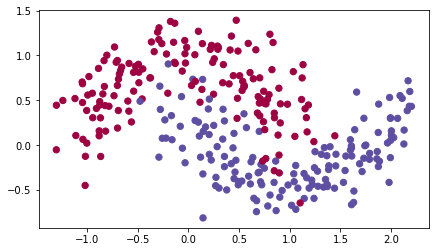

In [60]:
train_X, train_Y = load_dataset()

우리는 이미 3층 신경망을 구현했습니다. 다음과 같이 훈련합니다.

* Mini-batch Gradient Descent : 함수를 호출합니다.
   - `update_parameters_with_gd()`
* Mini-batch Momentum : 함수를 호출합니다.
   - `initialize_velocity()` 및 `update_parameters_with_momentum()`
* Mini-batch Adam : 함수를 호출합니다.
   - `initialize_adam()` 및 `update_parameters_with_adam()`

In [61]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 10000, print_cost = True):
    """
    3-layer neural network model which can be run in different optimizer modes.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    m = X.shape[1]                   # number of training examples
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            a3, caches = forward_propagation(minibatch_X, parameters)

            # Compute cost and add to the cost total
            cost_total += compute_cost(a3, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        cost_avg = cost_total / m
                # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

이제 3 가지 최적화 방법 각각을 사용하여이 3층 신경망을 실행합니다.

#### 5.1. 미니-배치 경사하강법
다음 코드를 실행하여 모델이 미니-배치 경사하강법을 사용하는 방법을 확인합니다.

Cost after epoch 0: 0.702405
Cost after epoch 1000: 0.668101
Cost after epoch 2000: 0.635288
Cost after epoch 3000: 0.600491
Cost after epoch 4000: 0.573367
Cost after epoch 5000: 0.551977
Cost after epoch 6000: 0.532370
Cost after epoch 7000: 0.514007
Cost after epoch 8000: 0.496472
Cost after epoch 9000: 0.468014


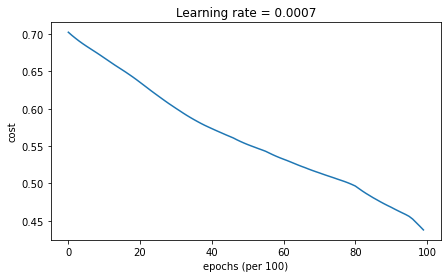

Accuracy: 0.7966666666666666


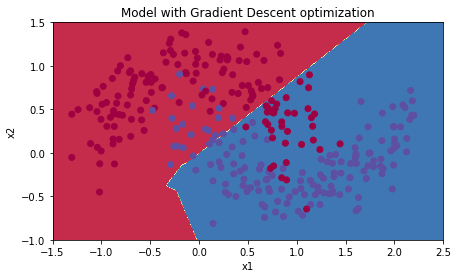

In [62]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
y = train_Y.reshape(train_Y.shape[1],)
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, y)

#### 5.2. 모멘텀이 있는 미니-배치 경사하강법
다음 코드를 실행하여 모델이 모멘텀으로 어떻게 작동하는지 확인하십시오. 이 예제는 비교적 간단하기 때문에 momemtum을 사용하여 얻을 수있는 이점은 적습니다. 그러나 더 복잡한 문제의 경우 더 큰 이득을 볼 수 있습니다.

Cost after epoch 0: 0.702413
Cost after epoch 1000: 0.668167
Cost after epoch 2000: 0.635388
Cost after epoch 3000: 0.600591
Cost after epoch 4000: 0.573444
Cost after epoch 5000: 0.552058
Cost after epoch 6000: 0.532458
Cost after epoch 7000: 0.514101
Cost after epoch 8000: 0.496652
Cost after epoch 9000: 0.468160


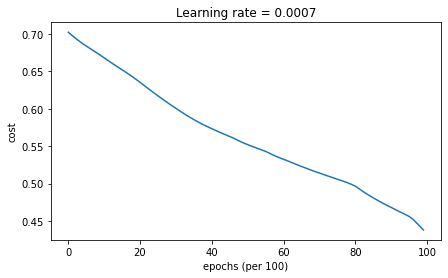

Accuracy: 0.7966666666666666


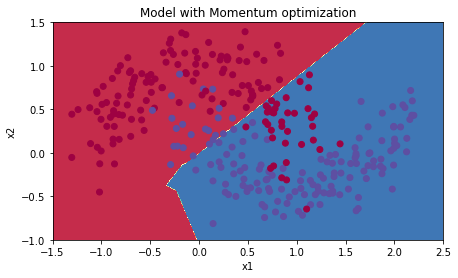

In [63]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer = "momentum")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
y = train_Y.reshape(train_Y.shape[1],)
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, y)

#### 5.3. Adam 모드를 사용한 미니-배치
다음 코드를 실행하여 모델이 Adam과 어떻게 작동하는지 확인합니다.

Cost after epoch 0: 0.702166
Cost after epoch 1000: 0.167845
Cost after epoch 2000: 0.141316
Cost after epoch 3000: 0.138788
Cost after epoch 4000: 0.136066
Cost after epoch 5000: 0.134240
Cost after epoch 6000: 0.131127
Cost after epoch 7000: 0.130216
Cost after epoch 8000: 0.129623
Cost after epoch 9000: 0.129118


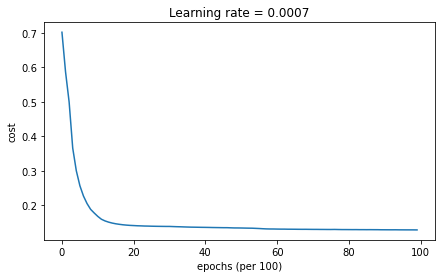

Accuracy: 0.94


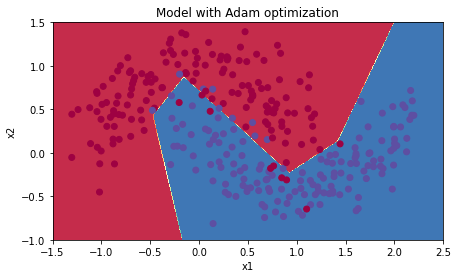

In [64]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
y = train_Y.reshape(train_Y.shape[1],)
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, y)

#### 5.4. 요약

<table border="1">
    <tr>
        <th>최적화 방법</th>
        <th>정확성</th>
        <th>비용 형태</th>
    </tr>
    <tr>
        <td>경사 하강 법 </td>
        <td>79.7 %</td>
        <td>진동</td>
    </tr>
    <tr>
        <td>모멘텀 </td>
        <td>79.7 %</td>
        <td> 진동</td>
    </tr>
    <tr>
        <td>Adam</td>
        <td>94 %</td>
        <td>더 부드러움</td>
    </tr>
 </table>
    
Momentum은 일반적으로 도움이되지만 학습률이 낮고 데이터 세트가 단순하기 때문에 그 영향은 거의 무시할 수 있습니다. 또한 비용에서 볼 수있는 큰 진동은 최적화 알고리즘에서 일부 미니 배치가 다른 미니 배치보다 더 어렵다는 사실에서 비롯됩니다.

반면에 Adam은 미니 배치 경사 하강 법과 모멘텀을 분명히 능가합니다. 이 간단한 데이터 세트에서 더 많은 에포크를 위해 모델을 실행하면 세 가지 방법 모두 매우 좋은 결과를 얻을 수 있습니다. 그러나 Adam이 훨씬 더 빠르게 수렴하는 것을 보았습니다.

Adam의 장점은 다음과 같습니다.

* 상대적으로 낮은 메모리 요구 사항 (경사 하강 및 운동량을 사용한 경사 하강보다 높음)
* 일반적으로 하이퍼 파라미터를 약간 조정해도 잘 작동합니다 ($ \alpha $ 제외).

**참조**
* Adam paper: https://arxiv.org/pdf/1412.6980.pdf